In [3]:
from transformers import AutoTokenizer
import pprint
from collections import Counter
import numpy as np
import json
from tqdm import tqdm
import itertools

In [4]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokens = tokenizer("Hello world")["input_ids"]
print(tokens)

[15496, 995]


In [6]:
# pprint.pprint(vars(tokenizer))
vocab1 = tokenizer.get_vocab()
print(type(vocab1))
print('vocab1 length:', len(vocab1))

print(list(vocab1.keys())[0])
print(type(list(vocab1.keys())[0]))


print()


print(tokenizer.vocab_size)
print(type(tokenizer.vocab))
vocab2 = tokenizer.vocab.copy()
print('vocab2 length:', len(vocab2))

print(list(vocab2.keys())[0])
print(type(list(vocab2.keys())[0]))

# 所以此二法得到的 vocab 是等价的


<class 'dict'>
vocab1 length: 50257
igen
<class 'str'>

50257
<class 'dict'>
vocab2 length: 50257
igen
<class 'str'>


为什么在前步骤中 直接打印 vocab.keys() 会出现奇怪的 字符 "Ġ" 呢?

In [7]:
print(vocab1['Ġexce']) # 得到 43748

print(tokenizer.decode(43748))

43748
 exce


In [8]:
# Read data from jsonl file
# Run tokenizer on each line of jsonl

test_data_file = '../data/webtext.test.jsonl'
with open(test_data_file, 'r') as f:
    test_data = f.readlines()
print(len(test_data), 'lines read from', test_data_file)

5000 lines read from ../data/webtext.test.jsonl


In [9]:
token_ids_list = []
for line in tqdm(test_data):
    json_obj = json.loads(line)
    text = json_obj['text']
    toks = tokenizer(text)['input_ids']
    token_ids_list.append(toks)

# print(token_ids_list[-1])
print(len(token_ids_list))
print(sum(map(len, token_ids_list)))
token_ids = itertools.chain.from_iterable(token_ids_list)
token_ids = list(token_ids)
print(len(token_ids))

100%|██████████| 5000/5000 [00:05<00:00, 961.56it/s] 

5000
2900278
2900278


In [14]:
tokens_count = Counter(token_ids)
# print(tokens_count.most_common(10))

top_ten_ids = [tok_id for tok_id, freq in tokens_count.most_common(10)]
print(top_ten_ids[0])

id0_decoded = tokenizer.decode(top_ten_ids[0])
print(type(id0_decoded))
print(len(id0_decoded))
print(chr(top_ten_ids[0]))

print('decode result:', tokenizer.decode(top_ten_ids[0]))
print('_convert_id_to_token result:', tokenizer._convert_id_to_token(top_ten_ids[0]))

print()
print('top 10 tokens with freqs:')
for tok_id, freq in tokens_count.most_common(10):
    print('\t'.join([str(tok_id), 
                     tokenizer.decode(tok_id).encode("unicode_escape").decode("utf-8"), 
                     str(freq)]))

198
<class 'str'>
1
Æ
decode result: 

_convert_id_to_token result: Ċ

top 10 tokens with freqs:
198	\n	114175
262	 the	106091
11	,	103121
13	.	102301
284	 to	57840
286	 of	53223
290	 and	50286
257	 a	46314
287	 in	36187
12	-	25145


如果直接打印 chr(198)，或者用 tokenizer._convert_id_to_token(198)，会出现错误字符

According to this post: https://github.com/huggingface/transformers/issues/3092

The proper way to decode a value is using the decode method:


```python
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

tokenizer.decode([198])  # '\n'
```

Some byte indices are shifted in the GPT-2 vocabulary, especially the control characters and characters that resemble whitespace. This is an example, and you can see the method that does it in `~transformers.tokenization_gpt2.bytes_to_unicode`.

In [30]:
top_ten_ids[0]

correct_decoded_ch = tokenizer.decode(top_ten_ids[0])
print(ord(correct_decoded_ch))

wrong_decoded_ch = tokenizer._convert_id_to_token(top_ten_ids[0])
print(wrong_decoded_ch)

10
Ċ


以上实验证明，正确的 token_id => token 的解码方式是 tokenizer.decode()

In [15]:
# 词频最低的是哪些词？
tokens_count.most_common()[-10:]

print('top 10 least frequent tokens:')
for tok_id, freq in tokens_count.most_common()[-10:]:
    print('\t'.join([str(tok_id), 
                     tokenizer.decode(tok_id).encode("unicode_escape").decode("utf-8"), 
                     str(freq)]))

top 10 least frequent tokens:
38340	UME	1
32567	 CHR	1
47550	 STA	1
44428	 GOLD	1
42887	 SERV	1
47821	 Balloon	1
47231	Prin	1
35713	..."	1
27629	 Zucker	1
49419	 lug	1


实现细节，可以参考 transformers 官方实现：https://github.com/huggingface/transformers/blob/v4.32.1/src/transformers/tokenization_utils.py#L917


<BarContainer object of 1000 artists>

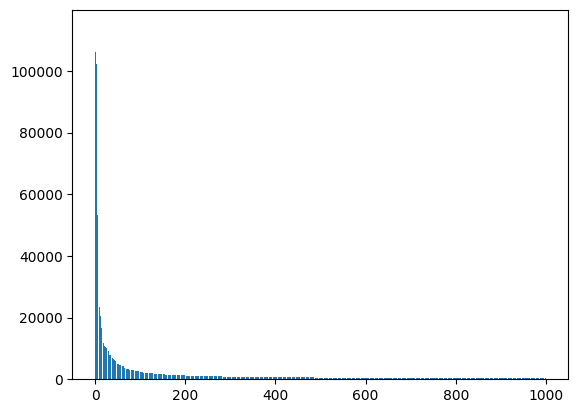

In [21]:
# bar plot
import matplotlib.pyplot as plt

num_plot = 1000

plt.bar(range(num_plot), 
        [freq for tok_id, freq in tokens_count.most_common(num_plot)],
        align='center')

<BarContainer object of 1000 artists>

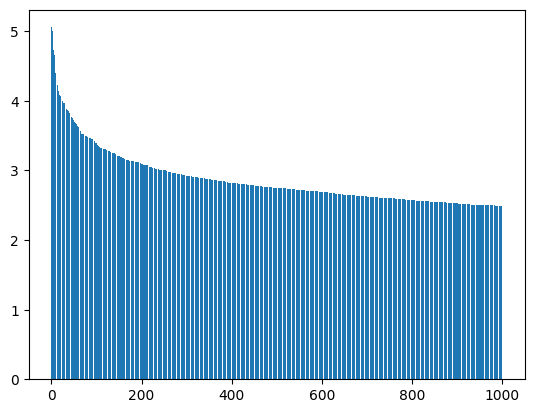

In [22]:
# log transformed count
num_plot = 1000

plt.bar(range(num_plot), 
        [np.log10(freq) for tok_id, freq in tokens_count.most_common(num_plot)],
        align='center')

<BarContainer object of 1000 artists>

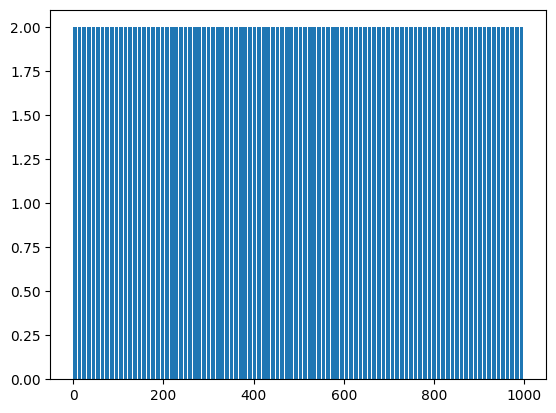

In [25]:
# low frequency tokens in a range of rank
hi_rank = -5000
lo_rank = -4000
num_plot = np.abs(hi_rank - lo_rank)

plt.bar(range(num_plot), 
        [freq for tok_id, freq in tokens_count.most_common()[hi_rank:lo_rank]],
        align='center')

In [ ]:
# 只关注词语，non-punct